In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Lasso
from itertools import compress
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns 

In [117]:
PATH = './data/'
train_data = pd.read_csv(PATH + 'train_data.csv')
test_data_x = pd.read_csv(PATH + 'test_features.csv')

In [118]:
train_data_y = train_data['poi']
train_data_x = train_data.drop(columns = 'poi')

In [119]:
# EDA 
# name and email address data seems not useful for prediction
train_data_x = train_data_x.drop(columns = ['name', 'email_address'])
train_data_x.dtypes

bonus                        float64
deferral_payments            float64
deferred_income              float64
director_fees                float64
exercised_stock_options      float64
expenses                     float64
from_messages                float64
from_poi_to_this_person      float64
from_this_person_to_poi      float64
loan_advances                float64
long_term_incentive          float64
other                        float64
restricted_stock             float64
restricted_stock_deferred    float64
salary                       float64
shared_receipt_with_poi      float64
to_messages                  float64
total_payments               float64
total_stock_value            float64
dtype: object

In [120]:
# null item num
for col in train_data_x.columns:
    if train_data_x[train_data_x[col].isnull()].shape[0] > 0:
        print (col + ' : ' + str(train_data_x[train_data_x[col].isnull()].shape[0]))
        
# base on column description, null items seems could be replaced by 0
train_data_x = train_data_x.fillna(0)
test_data_x = test_data_x.fillna(0)

bonus : 52
deferral_payments : 85
deferred_income : 79
director_fees : 100
exercised_stock_options : 32
expenses : 40
from_messages : 48
from_poi_to_this_person : 48
from_this_person_to_poi : 48
loan_advances : 111
long_term_incentive : 64
other : 44
restricted_stock : 31
restricted_stock_deferred : 103
salary : 40
shared_receipt_with_poi : 48
to_messages : 48
total_payments : 17
total_stock_value : 15


19


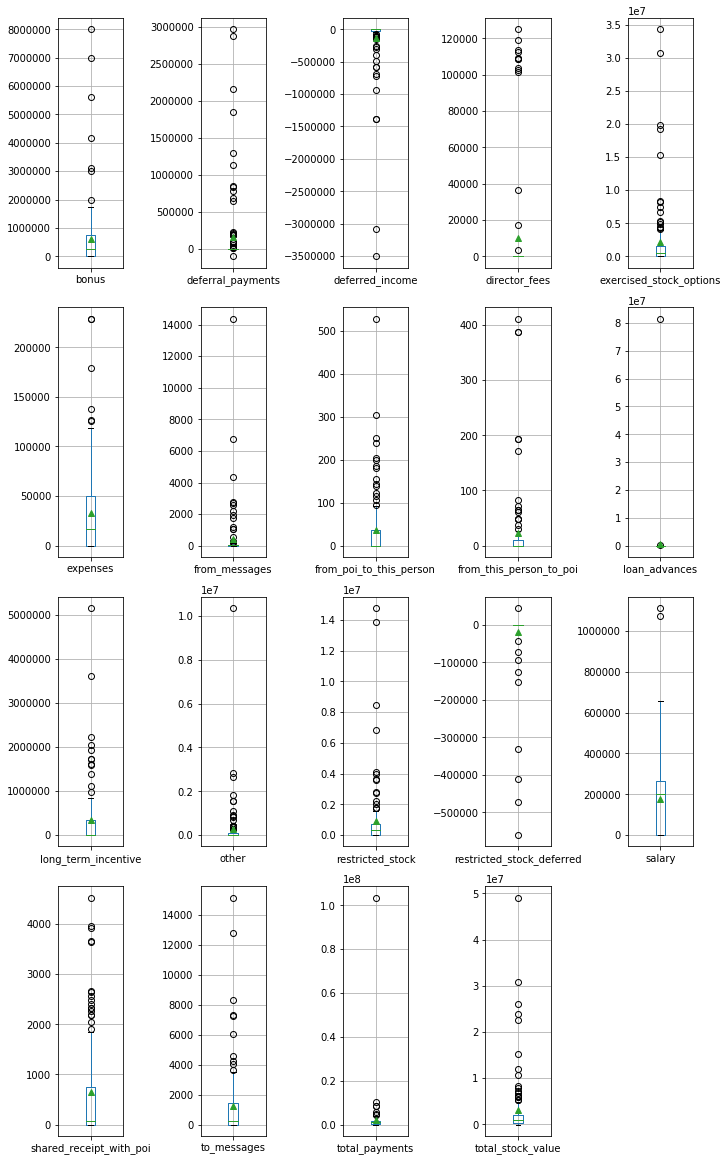

In [121]:
print(len(train_data_x.columns))

plt.figure(figsize=(10,20))
for idx, col in enumerate(train_data_x.columns):
    
    df_tmp = train_data_x[[col]]
    plt.subplot(5, 5, idx + 1)
    df_tmp.boxplot(vert=True,showmeans=True)
        
plt.tight_layout()

In [122]:
# if more outlier and outlier seems near IQR chart and more continuos, we try to normalize the feature
# normalization
nor_col_list = ['deferral_payments', 'deferred_income', 'exercised_stock_options','from_messages', 'from_poi_to_this_person',
               'from_this_person_to_poi', 'other', 'restricted_stock', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']

train_data_x[nor_col_list] = StandardScaler().fit_transform(train_data_x[nor_col_list])
test_data_x[nor_col_list] = StandardScaler().fit_transform(test_data_x[nor_col_list])

In [123]:
# if less outlier and outlier seems far from IQR chart, we try discretization
# discretization
dis_col_list = ['bonus', 'director_fees', 'expenses', 'loan_advances', 'long_term_incentive', 'restricted_stock_deferred',
               'salary']

colname_list= []
bins_arr_list = []
for col in dis_col_list:
    bins = pd.cut(train_data_x[col], 5, retbins=True, labels=False)[1] #only get array
    train_data_x[col] = pd.cut(train_data_x[col], 5)
    
    colname_list.append('low_'+ col)
    colname_list.append('med_low_'+ col)
    colname_list.append('med_'+ col)
    colname_list.append('med_high_'+ col)
    colname_list.append('high_'+ col)
    bins_arr_list.append(bins)

df_discrete_train = pd.get_dummies(train_data_x[dis_col_list])
df_discrete_train.columns = colname_list

for idx, col in enumerate(dis_col_list):
    test_data_x[col] = pd.cut(test_data_x[col], bins_arr_list[idx])

df_discrete_test =  pd.get_dummies(test_data_x[dis_col_list])
df_discrete_test.columns = colname_list

In [124]:
df_discrete_test.columns

Index(['low_bonus', 'med_low_bonus', 'med_bonus', 'med_high_bonus',
       'high_bonus', 'low_director_fees', 'med_low_director_fees',
       'med_director_fees', 'med_high_director_fees', 'high_director_fees',
       'low_expenses', 'med_low_expenses', 'med_expenses', 'med_high_expenses',
       'high_expenses', 'low_loan_advances', 'med_low_loan_advances',
       'med_loan_advances', 'med_high_loan_advances', 'high_loan_advances',
       'low_long_term_incentive', 'med_low_long_term_incentive',
       'med_long_term_incentive', 'med_high_long_term_incentive',
       'high_long_term_incentive', 'low_restricted_stock_deferred',
       'med_low_restricted_stock_deferred', 'med_restricted_stock_deferred',
       'med_high_restricted_stock_deferred', 'high_restricted_stock_deferred',
       'low_salary', 'med_low_salary', 'med_salary', 'med_high_salary',
       'high_salary'],
      dtype='object')

In [125]:
train_data_x = pd.concat([train_data_x[nor_col_list], df_discrete_train], axis = 1)
test_data_x = pd.concat([test_data_x[nor_col_list], df_discrete_test], axis = 1)

In [126]:
train_data_x

,deferral_payments,deferred_income,exercised_stock_options,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,shared_receipt_with_poi,to_messages,...,low_restricted_stock_deferred,med_low_restricted_stock_deferred,med_restricted_stock_deferred,med_high_restricted_stock_deferred,high_restricted_stock_deferred,low_salary,med_low_salary,med_salary,med_high_salary,high_salary
0,-0.313228,-6.921375,3.376960,-0.244431,0.062021,-0.273178,-0.092369,0.824892,0.217078,-0.141485,...,0,0,0,0,1,0,1,0,0,0
1,-0.313228,0.286256,3.272869,-0.188192,0.665743,0.099430,-0.235995,2.692598,1.355035,1.007405,...,0,0,0,0,1,0,0,0,0,1
2,-0.313228,0.277686,-0.098577,-0.231308,-0.318586,-0.129867,1.222862,-0.032111,-0.529646,-0.428496,...,0,0,0,0,1,1,0,0,0,0
3,-0.313228,0.286256,-0.409294,-0.255678,-0.489203,-0.330502,0.596677,0.020706,-0.617552,-0.523464,...,0,0,0,0,1,0,1,0,0,0
4,-0.313228,-0.253639,-0.409294,-0.165697,2.122551,0.027774,-0.256343,-0.371051,1.496072,0.573089,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.313228,0.286256,-0.409294,-0.255678,-0.489203,-0.330502,0.078074,-0.195146,-0.617552,-0.523464,...,0,0,0,0,1,0,1,0,0,0
109,-0.313228,0.286256,-0.409294,-0.230059,-0.318586,-0.316171,-0.256800,-0.428527,0.117579,0.103741,...,0,0,0,0,1,1,0,0,0,0
110,-0.313228,0.286256,-0.403785,-0.213812,-0.397332,-0.330502,-0.256800,-0.428527,0.085701,-0.144440,...,0,0,0,0,1,0,0,1,0,0
111,-0.313228,0.286256,-0.409294,-0.243806,-0.436705,-0.230185,-0.256800,0.582694,-0.162563,-0.281614,...,0,0,0,0,1,1,0,0,0,0


In [127]:
test_data_x

,deferral_payments,deferred_income,exercised_stock_options,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,shared_receipt_with_poi,to_messages,...,low_restricted_stock_deferred,med_low_restricted_stock_deferred,med_restricted_stock_deferred,med_high_restricted_stock_deferred,high_restricted_stock_deferred,low_salary,med_low_salary,med_salary,med_high_salary,high_salary
0,0.133179,-0.232306,-0.192227,0.528684,2.911562,0.760902,-0.196138,-0.196022,4.003821,4.270088,...,0,0,0,0,1,1,0,0,0,0
1,-0.252171,0.252766,-0.210145,-0.280602,1.537854,-0.129040,-0.224529,-0.191778,0.617387,0.437547,...,0,0,0,0,1,0,1,0,0,0
2,-0.252171,-0.394976,-0.106035,-0.271748,-0.148062,-0.071625,-0.223208,-0.164782,0.136321,-0.070501,...,0,0,0,0,1,0,1,0,0,0
3,-0.252171,0.252940,-0.167074,5.106377,0.382690,5.555107,-0.224524,-0.143667,1.051899,1.209304,...,0,0,0,0,1,0,1,0,0,0
4,-0.252171,0.204091,-0.210145,-0.241643,0.257807,-0.157748,-0.182939,-0.090713,0.610490,0.458794,...,0,0,0,0,1,0,1,0,0,0
5,-0.252171,0.252940,-0.210145,-0.280602,-0.023179,-0.263010,-0.224486,-0.183286,0.019933,0.101348,...,0,0,0,0,1,1,0,0,0,0
6,0.902970,-0.446942,-0.014004,-0.291227,3.130107,-0.215164,0.783871,-0.014955,1.812295,1.323037,...,0,0,0,0,1,0,0,0,0,1
7,-0.252171,0.232406,-0.210145,-0.328415,-0.647592,-0.272579,-0.224749,-0.201641,-0.755981,-0.723526,...,0,0,0,0,1,1,0,0,0,0
8,-0.252171,0.190580,-0.195746,-0.289456,2.287149,-0.167317,-0.224628,-0.188947,-0.090419,-0.182983,...,0,0,0,0,1,0,1,0,0,0
9,-0.242939,0.211367,-0.131928,-0.328415,-0.647592,-0.272579,-0.197312,-0.194049,-0.755981,-0.723526,...,0,0,0,1,0,1,0,0,0,0


In [128]:
# feature selection L1 embedding
L1_Reg = Lasso(alpha=0.001)
L1_Reg.fit(train_data_x, train_data_y)
print(L1_Reg.coef_)

GBDT = GradientBoostingClassifier()
GBDT.fit(train_data_x, train_data_y)
print(GBDT.feature_importances_)

[-0.05032417 -0.08279863  0.11849681 -0.00990158  0.07956344 -0.00834404
 -0.         -0.01221923 -0.         -0.03586364 -0.          0.
  0.15336342 -0.         -0.          0.51176443 -0.2713083   0.02789516
  0.          0.          0.         -0.0478264  -0.01759754  0.
  0.52081633  0.         -0.0173665   0.          0.          0.
  0.         -0.          0.          0.         -0.         -0.
 -0.         -0.         -0.          0.          0.          0.03693779
 -0.02812856  0.00564624 -0.          0.          0.0482633 ]
[1.52976203e-03 1.26088245e-01 3.26078232e-01 1.07182489e-02
 4.24133745e-02 1.13340982e-02 6.48519040e-02 9.58581827e-02
 1.14786402e-02 3.70165626e-02 4.50633759e-02 8.81560275e-02
 3.60975215e-03 0.00000000e+00 0.00000000e+00 4.40689401e-03
 1.62647342e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.83450192e-06 1.39178738e-02 0.00000000e+00
 1.10175856e-01 0.00000000e+00 0.00000000e+00 2.30444318e-05
 0.00000000e+00 0.00000000e+00 0

In [129]:
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<-0))
select_feat_L1 = list(compress(list(train_data_x.columns), list(L1_mask)))
print(select_feat_L1)

GDBT_mask = list((GBDT.feature_importances_>0) | (GBDT.feature_importances_<-0))
select_feat_GBDT = list(compress(list(train_data_x.columns), list(GDBT_mask)))
print(select_feat_GBDT)

['deferral_payments', 'deferred_income', 'exercised_stock_options', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'restricted_stock', 'to_messages', 'low_bonus', 'med_high_bonus', 'high_bonus', 'low_director_fees', 'high_director_fees', 'low_expenses', 'med_expenses', 'high_expenses', 'high_restricted_stock_deferred', 'low_salary', 'med_low_salary', 'high_salary']
['deferral_payments', 'deferred_income', 'exercised_stock_options', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other', 'restricted_stock', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value', 'low_bonus', 'med_high_bonus', 'high_bonus', 'high_director_fees', 'low_expenses', 'med_expenses', 'low_loan_advances', 'low_long_term_incentive', 'med_low_long_term_incentive', 'low_salary', 'med_low_salary', 'high_salary']


In [130]:
# using GBDT to do prediction

# dividing training and validation set
train_data_x_new, val_data_x, train_data_y_new, val_data_y = train_test_split(train_data_x, train_data_y, test_size = 0.2, random_state = 0)

GBDT = GradientBoostingClassifier(min_samples_split = 4, min_samples_leaf = 5, max_depth = 7, max_features = 'sqrt', subsample = 0.8)
GBDT.fit(train_data_x_new, train_data_y_new)

val_pre_y = GBDT.predict(val_data_x)

In [131]:
mat = confusion_matrix(val_data_y, val_pre_y)
print(mat)

[[19  1]
 [ 3  0]]


In [132]:
# using all features
GBDT = GradientBoostingClassifier(min_samples_split = 4, min_samples_leaf = 5, max_depth = 7, max_features = 'sqrt', subsample = 0.8)
cross_score = cross_val_score(GBDT, train_data_x, train_data_y, cv=5, scoring = 'roc_auc')
print(cross_score)

[0.83333333 0.86666667 0.9        0.75       0.925     ]


In [133]:
GBDT.fit(train_data_x, train_data_y)
pre_data_prob_y = GBDT.predict_proba(test_data_x)[:,1]
pre_data_y = GBDT.predict(test_data_x)
test_data_x['predict'] = pre_data_prob_y
test_data_x.to_csv(PATH + 'predict_data.csv')

In [134]:
pre_data_prob_y

array([1.79060146e-02, 8.99756873e-02, 9.91405334e-02, 2.53463448e-02,
       3.73066266e-01, 5.39816046e-02, 6.70670069e-02, 5.75854507e-04,
       1.44757107e-01, 6.58946480e-04, 9.40053292e-03, 4.13839556e-04,
       2.09264229e-02, 5.75854507e-04, 1.60186342e-02, 6.96483880e-04,
       7.34229634e-03, 4.78721437e-02, 1.96208785e-02, 5.45033196e-04,
       4.33763478e-01, 9.23862679e-01, 4.90853448e-02, 5.73643173e-04,
       3.95259029e-04, 8.04928144e-04, 2.00383855e-03, 6.63689870e-04,
       2.50640666e-02, 2.52516627e-01, 6.05143397e-04, 3.91764978e-03,
       7.58495292e-01])

In [135]:
pre_data_y

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True])

In [111]:
# using selected feature LASSO
train_data_x_L1 = train_data_x[select_feat_L1]
test_data_x_L1 = test_data_x[select_feat_L1]

cross_score = cross_val_score(GBDT, train_data_x_L1, train_data_y, cv=5, scoring = 'roc_auc')
print(cross_score)

[0.76666667 0.78333333 0.95       0.55       0.775     ]


In [112]:
# using selected feature GBDT
train_data_x_GBDT = train_data_x[select_feat_L1]
test_data_x_GBDT = test_data_x[select_feat_L1]

cross_score = cross_val_score(GBDT, train_data_x_GBDT, train_data_y, cv=5, scoring = 'roc_auc')
print(cross_score)

[0.81666667 0.8        0.9        0.5        0.775     ]


In [ ]:
# [0.8166667, 0.8, 0.8, 0.75, 0.825]
# [0.8        0.81666667 0.98333333 0.725      0.75      ]
#[0.81666667 0.78333333 0.96666667 0.625      0.95      ]
# [0.8   0.7   1.    0.725 0.825]

# [0.75       0.93333333 0.75       0.8        0.825     ]
# [0.76666667 0.93333333 0.73333333 0.8        0.825     ]
# [0.78333333 0.81666667 0.93333333 0.575      0.85      ]
# [0.76666667 0.8        1.         0.65       0.825     ]

#[0.68333333 0.8        0.96666667 0.625      0.9       ]
# [0.71666667 0.78333333 0.96666667 0.55       0.85      ]
# [0.76666667 0.81666667 0.95       0.725      0.8       ]
# [0.76666667 0.81666667 0.96666667 0.625      0.75      ]